In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
import sys, os, warnings, time, logging, re
import torch
import pytorch_lightning as pl
from pytorch_lightning.core.decorators import auto_move_data
from pathlib import Path
import PIL

import numpy as np
import matplotlib.pyplot as plt
import torchvision
from tqdm.autonotebook import tqdm

from lightning_addons.progressbar import ProgressBar
from lightning_addons.progressplotter import ProgressPlotter
from lightning_addons.progressprinter import ProgressPrinter

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
# this makes lightning reports not look like errors
pl._logger.handlers = [logging.StreamHandler(sys.stdout)]

# ImageDataset

In [3]:
def get_files(path, regex_filter=None):
    if regex_filter is not None:
        return [
            Path(file)
            for file in os.listdir(path)
            if re.search(regex_filter, str(file))
        ]
    return os.listdir(path)

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, root, img_transforms=None, seg_transforms=None):
        self.root = root
        if img_transforms:
            self.img_transform = torchvision.transforms.Compose(img_transforms)
        else:
            self.img_transform = None
        if seg_transforms:
            self.seg_transform = torchvision.transforms.Compose(seg_transforms)
        else:
            self.seg_transform = None

        seg_file_filter = ".*_seg\.tif"
        img_file_filter = ".*\.jpg"
        self.img_filenames = get_files(root, img_file_filter)
        self.seg_filenames = get_files(root, seg_file_filter)

    def __getitem__(self, index):
        img = PIL.Image.open(self.root / self.img_filenames[index])
        seg = PIL.Image.open(self.root / self.seg_filenames[index])
        if self.img_transform:
            img = self.img_transform(img)
        if self.seg_transform:
            seg = self.seg_transform(seg)
        return {"image": img, "segmentation": seg}

    def __len__(self):
        return len(self.img_filenames)
    
dataset = ImageDataset("/fastdata/ISPRS_BENCHMARK_DATASETS/Potsdam/processed/annotated_images/patches_300x300/training")
len(dataset)

9600

# PotsdamDataModule

In [4]:
# mean and std for "image"
image_mean, image_std = (torch.tensor([0.3421, 0.3642, 0.3392]), torch.tensor([0.1402, 0.1360, 0.1415]))
segmentation_mean, segmentation_std = (torch.tensor([0.3725, 0.6933, 0.7947]), torch.tensor([0.4819, 0.4601, 0.4021]))

In [5]:
class PotsdamDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: Path = './', 
                 batch_size: int = 64, num_workers: int = 8, 
                 x_norm_mean: float = 0.5, x_norm_std: float = 5,
                 y_norm_mean: float = 0.5, y_norm_std: float = 5,
    ):
        super().__init__()
        self.data_dir = Path(data_dir)
        self.batch_size = batch_size
        self.num_workers = num_workers
        
        # self.dims is returned when you call dm.size()
        # Setting default dims here because we know them.
        # Could optionally be assigned dynamically in dm.setup()
        self.dims = (3, 256, 256)
        
        
        self.img_transforms = [
            torchvision.transforms.Resize(self.dims[1]),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(x_norm_mean, x_norm_std)
        ]
        self.seg_transforms = [
            torchvision.transforms.Resize(self.dims[1]),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(y_norm_mean, y_norm_std)
        ]

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train_ds = ImageDataset(self.data_dir / "training", self.img_transforms, self.seg_transforms)

        if stage == 'test' or stage is None:
            self.test_ds = ImageDataset(self.data_dir / "test", self.img_transforms, self.seg_transforms)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_ds, batch_size=self.batch_size, num_workers=self.num_workers, pin_memory=True, shuffle=True)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_ds, batch_size=self.batch_size, num_workers=self.num_workers, pin_memory=True)
    
x_mean = image_mean
x_std = image_std
y_mean = segmentation_mean
y_std = segmentation_std
# y_mean = 0.5
# y_std = 0.5
    
batch_size = 64
data = PotsdamDataModule(
    "/fastdata/ISPRS_BENCHMARK_DATASETS/Potsdam/processed/annotated_images/patches_300x300/",
    batch_size,
    x_norm_mean=x_mean,
    x_norm_std=x_std,
    y_norm_mean=y_mean,
    y_norm_std=y_std,
)
data.prepare_data()
data.setup()
batch = next(iter(data.test_dataloader()))

In [6]:
batch["image"].shape, batch["segmentation"].shape

(torch.Size([64, 3, 256, 256]), torch.Size([64, 3, 256, 256]))

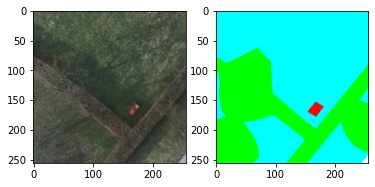

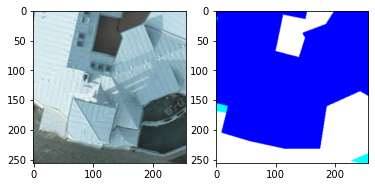

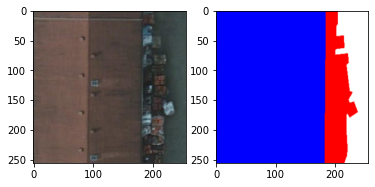

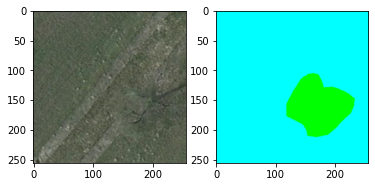

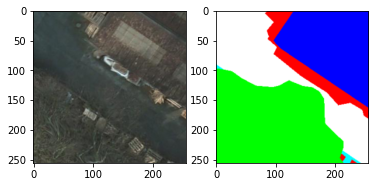

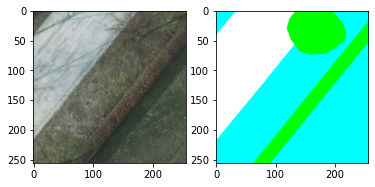

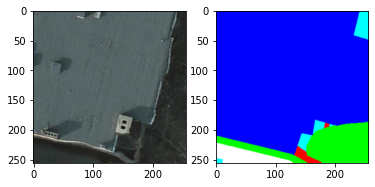

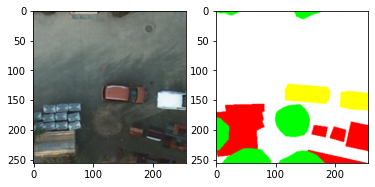

In [7]:
for i in range(0, batch_size, 8):
    f, axs = plt.subplots(1, 2)
    axs[0].imshow(batch["image"][i].permute(1, 2, 0).mul(image_std).add(image_mean))
#     axs[1].hist(batch["image"][i].reshape(-1).numpy())
    axs[1].imshow(batch["segmentation"][i].permute(1, 2, 0).mul(segmentation_std).add(segmentation_mean))

## find dataset mean and std

In [8]:
# # compute mean and std etc
# # input_key = "image"
# # target_key = "segmentation"
# input_key = "segmentation"
# target_key = "image"
# def collect_stats(sample):
#     image = sample[input_key]
#     return image.sum((1, 2)), (image ** 2).sum((1, 2))#, image.mean((1, 2)), image.min((1, 2)), image.max((1, 2))

# all_stats = [collect_stats(sample) for sample in tqdm(data.train_dataloader().dataset)]
# sums, squared_sums= [torch.stack(stats, 0) for stats in (zip(*all_stats))]
# # , means, mins, maxs 

# ds_mean = sums.mean(0) / (256 * 256)
# # ds_mean = means.mean(0)
# ds_std = (squared_sums.mean(0) / (256 * 256) - ds_mean ** 2).sqrt()
# ds_mean, ds_std

In [9]:
import torch.nn as nn
import functools

In [10]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True, upsample="conv"):
        super().__init__()
        self.upsample = upsample
        if upsample == "conv":
            self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=bias)
        elif upsample == "bilinear":
            self.upsampler = nn.Upsample(scale_factor=2.0, mode='bilinear', align_corners=True)
            self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=bias)
        
    def forward(self, x):
        if self.upsample == "conv":
            return self.conv(x)
        elif self.upsample == "bilinear":
            x_u = self.upsampler(x)
            return self.conv(x_u)
        
        
Up(128, 64, upsample="bilinear")(torch.empty(2, 128, 64, 64)).shape, Up(128, 64, upsample="conv")(torch.empty(2, 128, 64, 64)).shape

(torch.Size([2, 64, 128, 128]), torch.Size([2, 64, 128, 128]))

In [11]:
class UnetGenerator(nn.Module):
    """Create a Unet-based generator"""

    def __init__(self, input_nc, output_nc, num_downs, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, upsample="conv"):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            ngf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer
        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super(UnetGenerator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True, upsample=upsample)  # add the innermost layer
        for i in range(num_downs - 5):          # add intermediate layers with ngf * 8 filters
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout, upsample=upsample)
        # gradually reduce the number of filters from ngf * 8 to ngf
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, upsample=upsample)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer, upsample=upsample)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer, upsample=upsample)
        self.model = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer, upsample=upsample)  # add the outermost layer

    def forward(self, input):
        """Standard forward"""
        return self.model(input)
    

class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, 
                 norm_layer=nn.BatchNorm2d, use_dropout=False, output_activation=nn.Tanh(), upsample="conv"):
        """Construct a Unet submodule with skip connections.
        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = Up(inner_nc * 2, outer_nc, upsample=upsample)
            down = [downconv]
            up = [uprelu, upconv, output_activation]
            model = down + [submodule] + up
        elif innermost:
            upconv = Up(inner_nc, outer_nc, bias=use_bias, upsample=upsample)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = Up(inner_nc * 2, outer_nc, bias=use_bias, upsample=upsample)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)
        
input_channels = 3
output_channels = 3
num_downs = 7
generator = UnetGenerator(input_channels, output_channels, num_downs, upsample="bilinear")

generator(torch.empty(2, 3, 256, 256)).shape

torch.Size([2, 3, 256, 256])

In [12]:
class NLayerDiscriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(NLayerDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)

ndf = 64
discriminator = NLayerDiscriminator(input_channels, ndf, n_layers=3)

In [13]:
t = torch.empty(batch_size, input_channels, 256, 256)
discriminator(t).shape

torch.Size([64, 1, 30, 30])

In [20]:
class Pix2Pix(pl.LightningModule):
    def __init__(
        self, 
        input_channels, 
        height, 
        width, 
        output_channels, 
        lr, 
        batch_size,
        beta1=0.5,
        l1_lambda=100,
    ):
        super().__init__()
        self.save_hyperparameters()
        
        data_shape = (input_channels, width, height)
        
        num_downs = 8 # 8: 1x1, 7: 2x2
        self.generator = UnetGenerator(input_channels, output_channels, num_downs, upsample="bilinear")
        ndf = 64
        self.discriminator = NLayerDiscriminator(input_channels + output_channels, ndf, n_layers=3)
   
        self.test_x = None
        self.test_y = None
        self.example_input_array = torch.zeros(batch_size, input_channels, height, width)


    @auto_move_data
    def forward(self, x):
        return self.generator(x)
    
    def configure_optimizers(self):
        optimizer_generator = torch.optim.Adam(self.generator.parameters(), lr=self.hparams.lr, betas=(self.hparams.beta1, 0.999))
        optimizer_discriminator = torch.optim.Adam(self.discriminator.parameters(), lr=self.hparams.lr, betas=(self.hparams.beta1, 0.999))
        
        optimizers = [optimizer_generator, optimizer_discriminator]
        return optimizers
    
    def gan_criterion(self, preds, targets):
        return torch.nn.functional.mse_loss(preds, targets)

    def l1_criterion(self, preds, targets):
        return torch.nn.functional.l1_loss(preds, targets)
    
    def training_step(self, batch, batch_nb, optimizer_idx):
        real_x_imgs, real_y_imgs = batch["image"], batch["segmentation"]
        fake_y_imgs = self.generator(real_x_imgs)
        
        if optimizer_idx == 0:
            fake_y_real_x = torch.cat((fake_y_imgs, real_x_imgs), 1) 
            fake_pred = self.discriminator(fake_y_real_x)
            valid = torch.ones_like(fake_pred)
            fake = torch.zeros_like(fake_pred)
            gan_loss = self.gan_criterion(fake_pred, valid)
            
            l1_loss = self.l1_criterion(fake_y_imgs, real_y_imgs)
            
            loss = gan_loss + self.hparams.l1_lambda * l1_loss
            self.log("g_loss", loss)
            self.log("gan_loss", gan_loss)
            self.log("l1_loss", l1_loss)
        elif optimizer_idx == 1:
            real_y_real_x = torch.cat((real_y_imgs, real_x_imgs), 1) 
            real_pred = self.discriminator(real_y_real_x)
            valid = torch.ones_like(real_pred)
            fake = torch.zeros_like(real_pred)
            
            fake_y_real_x = torch.cat((fake_y_imgs.detach(), real_x_imgs), 1) 
            fake_pred = self.discriminator(fake_y_real_x)
            real_loss = self.gan_criterion(real_pred, valid)   
            fake_loss = self.gan_criterion(fake_pred, fake)
            loss = (real_loss + fake_loss) / 2
            
            self.log("d_loss", loss)
            self.log("real_loss", real_loss)
            self.log("fake_loss", fake_loss)
        self.log("loss", loss)
        return loss
        
    def on_epoch_end(self):
        if self.test_x is not None and self.test_y is not None:
            test_x = self.test_x.to(self.device).permute(0, 2, 3, 1).mul(x_std.to(self.device)).add(x_mean.to(self.device)).permute(0, 3, 1, 2)
            test_y = self.test_y.to(self.device).permute(0, 2, 3, 1).mul(y_std.to(self.device)).add(y_mean.to(self.device)).permute(0, 3, 1, 2)
            
            fake_y_imgs = self.generator(test_x).permute(0, 2, 3, 1).mul(y_std.to(self.device)).add(y_mean.to(self.device)).permute(0, 3, 1, 2)
            output = torch.cat((test_x, test_y, fake_y_imgs))
            grid = torchvision.utils.make_grid(output)#.add(1.0).div(2.0).clip(0.0, 1.0)
            self.logger[0].experiment.add_image(
                "generated_images", grid, self.current_epoch
            ) 
    
    def set_test_batch(self, test_batch, n_samples=8):
        self.test_x = test_batch["image"][:n_samples]
        self.test_y = test_batch["segmentation"][:n_samples]
        
lr = 1e-4
model = Pix2Pix(*data.size(), output_channels, lr, batch_size)
model.set_test_batch(next(iter(data.test_dataloader())))

In [21]:
# pl.core.memory.ModelSummary(model, mode="full")

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Using native 16bit precision.

  | Name          | Type                | Params | In sizes          | Out sizes        
----------------------------------------------------------------------------------------------
0 | generator     | UnetGenerator       | 39.2 M | [64, 3, 256, 256] | [64, 3, 256, 256]
1 | discriminator | NLayerDiscriminator | 2.8 M  | ?                 | ?                
----------------------------------------------------------------------------------------------
41.9 M    Trainable params
0         Non-trainable params
41.9 M    Total params


Training: 0it [00:00, ?it/s]

epoch,loss,g_loss,gan_loss,l1_loss,d_loss,real_loss,fake_loss,time
0,35.100000,61.280617,0.356165,0.609245,0.227026,0.238156,0.215896,0:00:10
1,30.400000,63.235817,0.385663,0.628502,0.174785,0.172187,0.177384,0:00:09
2,28.800000,58.979568,0.485156,0.584944,0.114520,0.100819,0.128220,0:00:09
3,27.700000,53.254040,0.610071,0.526440,0.108574,0.108397,0.108750,0:00:09
4,26.600000,51.179287,0.755450,0.504238,0.107641,0.116257,0.099026,0:00:09
5,25.800000,47.492779,0.786484,0.467063,0.060132,0.077693,0.042572,0:00:09
6,25.300000,50.607677,0.837301,0.497704,0.028402,0.032112,0.024691,0:00:09
7,24.900000,50.352707,1.227732,0.491250,0.292594,0.291425,0.293763,0:00:09
8,25.700000,46.950668,0.872274,0.460784,0.047878,0.076182,0.019574,0:00:09
9,24.300000,48.782337,1.100535,0.476818,0.049819,0.050244,0.049395,0:00:09


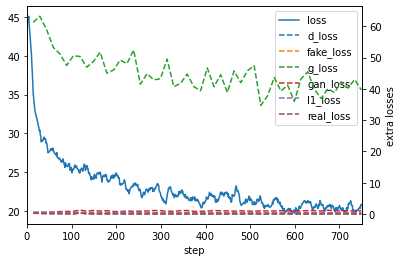

time 6e+02


In [22]:
tb_logger = pl.loggers.TensorBoardLogger("/home/mtadmin/projects/tensorboard_logs")
logger = [tb_logger]
# logger = []

plotter = ProgressPlotter()
callbacks = [
#     ProgressBar(),
    ProgressPrinter(),
    plotter,
]

trainer = pl.Trainer(
    max_epochs=50, 
#     fast_dev_run=True, 
    gpus=1,
    logger=logger,
    callbacks=callbacks,
    precision=16,
    limit_train_batches=0.1,
)

start_time = time.time()
trainer.fit(model, data)
print(f"time {time.time() - start_time:.2}")

In [ ]:
%debug